# Introduction
# Getting Ready for This Homework
# Programming Tasks
## Sentiment Analysis with Your Own GRU

In [1]:
import os
import sys
import gzip
import pickle
import random

import numpy as np
import torch
# want notebook to be self-contained, so copied word2vec dataloader from DLStudio
# and modified it a bit
class SentimentAnalysisDataset(torch.utils.data.Dataset):
    """
    In relation to the SentimentAnalysisDataset defined for the TextClassification section of 
    DLStudio, the __getitem__() method of the dataloader must now fetch the embeddings from
    the word2vec word vectors.

    Class Path:  DLStudio -> TextClassificationWithEmbeddings -> SentimentAnalysisDataset
    """
    def __init__(self, dataroot, train_or_test, dataset_file, path_to_saved_embeddings=None):
        super().__init__()
        import gensim.downloader as gen_api
        self.path_to_saved_embeddings = path_to_saved_embeddings
        self.train_or_test = train_or_test
        root_dir = dataroot
        f = gzip.open(root_dir + dataset_file, 'rb')
        dataset = f.read()
        if path_to_saved_embeddings is not None:
            import gensim.downloader as genapi
            from gensim.models import KeyedVectors 
            if os.path.exists(path_to_saved_embeddings + 'vectors.kv'):
                self.word_vectors = KeyedVectors.load(path_to_saved_embeddings + 'vectors.kv')
            else:
                print("""\n\nSince this is your first time to install the word2vec embeddings, it may take"""
                      """\na couple of minutes. The embeddings occupy around 3.6GB of your disk space.\n\n""")
                self.word_vectors = genapi.load("word2vec-google-news-300")               
                ##  'kv' stands for  "KeyedVectors", a special datatype used by gensim because it 
                ##  has a smaller footprint than dict
                self.word_vectors.save(path_to_saved_embeddings + 'vectors.kv')    
        if train_or_test == 'train':
            if sys.version_info[0] == 3:
                self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset, encoding='latin1')
            else:
                self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset)
            self.categories = sorted(list(self.positive_reviews_train.keys()))
            self.category_sizes_train_pos = {category : len(self.positive_reviews_train[category]) for category in self.categories}
            self.category_sizes_train_neg = {category : len(self.negative_reviews_train[category]) for category in self.categories}
            self.indexed_dataset_train = []
            for category in self.positive_reviews_train:
                for review in self.positive_reviews_train[category]:
                    self.indexed_dataset_train.append([review, category, 1])
            for category in self.negative_reviews_train:
                for review in self.negative_reviews_train[category]:
                    self.indexed_dataset_train.append([review, category, 0])
            random.shuffle(self.indexed_dataset_train)
        elif train_or_test == 'test':
            if sys.version_info[0] == 3:
                self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset, encoding='latin1')
            else:
                self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset)
            self.vocab = sorted(self.vocab)
            self.categories = sorted(list(self.positive_reviews_test.keys()))
            self.category_sizes_test_pos = {category : len(self.positive_reviews_test[category]) for category in self.categories}
            self.category_sizes_test_neg = {category : len(self.negative_reviews_test[category]) for category in self.categories}
            self.indexed_dataset_test = []
            for category in self.positive_reviews_test:
                for review in self.positive_reviews_test[category]:
                    self.indexed_dataset_test.append([review, category, 1])
            for category in self.negative_reviews_test:
                for review in self.negative_reviews_test[category]:
                    self.indexed_dataset_test.append([review, category, 0])
            random.shuffle(self.indexed_dataset_test)

    def review_to_tensor(self, review):
        list_of_embeddings = []
        for i,word in enumerate(review):
            if word in self.word_vectors.key_to_index:
                embedding = self.word_vectors[word]
                list_of_embeddings.append(np.array(embedding))
            else:
                next
        review_tensor = torch.FloatTensor( np.array(list_of_embeddings) )
        return review_tensor

    def sentiment_to_tensor(self, sentiment):
        """
        Sentiment is ordinarily just a binary valued thing.  It is 0 for negative
        sentiment and 1 for positive sentiment.  We need to pack this value in a
        two-element tensor.
        """        
        sentiment_tensor = torch.zeros(2)
        if sentiment == 1:
            sentiment_tensor[1] = 1
        elif sentiment == 0: 
            sentiment_tensor[0] = 1
        sentiment_tensor = sentiment_tensor.type(torch.long)
        return sentiment_tensor

    def __len__(self):
        if self.train_or_test == 'train':
            return len(self.indexed_dataset_train)
        elif self.train_or_test == 'test':
            return len(self.indexed_dataset_test)

    def __getitem__(self, idx):
        sample = self.indexed_dataset_train[idx] if self.train_or_test == 'train' else self.indexed_dataset_test[idx]
        review = sample[0]
        review_category = sample[1]
        review_sentiment = sample[2]
        review_sentiment = self.sentiment_to_tensor(review_sentiment)
        review_tensor = self.review_to_tensor(review)
        category_index = self.categories.index(review_category)
        sample = {'review'       : review_tensor, 
                  'category'     : category_index, # should be converted to tensor, but not yet used
                  'sentiment'    : review_sentiment }
        return sample

In [2]:
dlstudio_examples = "/home/moiz/courses/ece60146/DLStudio/Examples/"
dataroot = dlstudio_examples + "data/TextDatasets/sentiment_dataset/"
embeddings_path = dlstudio_examples + "data/TextDatasets/word2vec/"

In [3]:
trainDataset = SentimentAnalysisDataset(dataroot, train_or_test="train", dataset_file="sentiment_dataset_train_400.tar.gz", path_to_saved_embeddings=embeddings_path)

In [4]:
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size=1 ,shuffle=True, num_workers=2)

In [5]:
print(trainDataset[50]["review"].shape)
print(len(trainDataset))

torch.Size([50, 300])
14227


In [3]:
import torch.nn as nn

class MyGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.bidirectional = False
        self.update_gate_hidden = nn.Linear(hidden_size, hidden_size)
        self.update_gate_input = nn.Linear(input_size, hidden_size)
        self.reset_gate_hidden = nn.Linear(hidden_size, hidden_size)
        self.reset_gate_input = nn.Linear(input_size, hidden_size)
        self.cand_hidden_hidden = nn.Linear(hidden_size, hidden_size)
        self.cand_hidden_input = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def compute_token(self, token, hidden):
        z = self.sigmoid(self.update_gate_input(token) + self.update_gate_hidden(hidden))
        r = self.sigmoid(self.reset_gate_input(token) +  self.reset_gate_hidden(hidden))
        candh = self.tanh(self.cand_hidden_input(token) + self.cand_hidden_hidden(r * hidden))
        newh = (1-z)*hidden + z*candh
        return newh
        
    def forward(self, x, hidden):
        if x.size(0) == 1: 
            h = self.compute_token(x, hidden)
            return h, h
        else:
            output = torch.zeros(x.size(0), x.size(1), self.hidden_size).to(next(self.parameters()).device)
            for i, token in enumerate(x):
                hidden = self.compute_token(token, hidden)
                output[i] = hidden
            return output, hidden

The above is my implementation of a Gated Recurrence Unit (GRU).
It adheres to the equations described in the lecture slides.
I realized after implementation that the linear networks for the input and hidden vector could be combined, which could possibly speed up the network. 
I didn't do it initially because I was confused about it when I saw it in the notes, but now I realise I was being done and can be thought of as block matrix multiplication.

I think the gating mechanisms are a means to an end for why the gradient vanishing problem is mitigated here.
I think the main reason is that the hidden vector acts as a skip connection between the computation of different sequence elements.
The gating mechanims simply are a method of adding information to or deleing information from the hidden state "thread" that runs through all the sequence elements. 

In [4]:
class SentimentGRUWrapper(nn.Module):
    def __init__(self, gru, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.gru = gru
        self.out_size = gru.hidden_size*2 if gru.bidirectional else gru.hidden_size
        self.linear = nn.Linear(self.out_size, 2)
        self.numhidden = 2 if gru.bidirectional else 1
    
    def forward(self, x):
        hidden = torch.zeros(self.numhidden, self.batch_size, self.gru.hidden_size).to(next(self.gru.parameters()).device)
        out, hid = self.gru(x, hidden)
        out = out[-1,:,:].view(-1, self.out_size)
        return self.linear(out)

In [8]:
import numpy as np

def train(model, dataloader):
    model.train()
    
    losses = list()
    device = torch.device('cuda')
    disc = model.to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
        
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.99))
    
    lossRun = 0
        
    epochs = 4
    numiters = 0
    for epoch in range(epochs):
        for i, data in enumerate(dataloader):
            review, sentiment = data['review'], data['sentiment']
            review = review.transpose(0, 1).to(device)
            sentiment = sentiment.to(device)
            
            optimizer.zero_grad()
            sentPred = model(review)
            loss = criterion(sentPred, torch.argmax(sentiment, 1))
            lossRun += loss.item()
            loss.backward()
            optimizer.step()
            
            if (numiters + 1) % 100 == 0:
                losses.append(lossRun/100)
                lossRun = 0
            if (numiters + 1) % 1000 == 0:
                print(f"completed numiters {numiters} epoch {epoch}: Losses: {losses[-1]}")
            numiters += 1 

    return np.array(losses)

In [5]:
myGruModel = SentimentGRUWrapper(MyGRU(300, 100), 1)
# losses = train(myGruModel, trainDataloader)

# torch.save(myGruModel.state_dict(), "mygru_sentiment_model")
# np.savetxt("mygru_train_loss", losses)

myGruModel.load_state_dict(torch.load("mygru_sentiment_model"))
losses = np.loadtxt("mygru_train_loss")

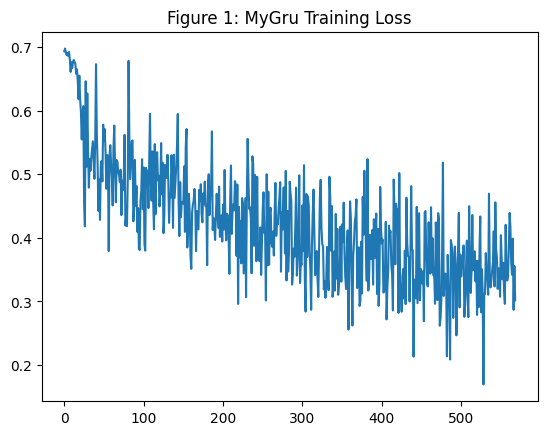

In [6]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Figure 1: MyGru Training Loss")
plt.show()

In [7]:
testDataset = SentimentAnalysisDataset(dataroot, train_or_test="test", dataset_file="sentiment_dataset_test_400.tar.gz", path_to_saved_embeddings=embeddings_path)

In [8]:
testDataloader = torch.utils.data.DataLoader(testDataset, batch_size=1, shuffle=True, num_workers=2)

In [9]:
def test(net, dataset, dataloader):
    net.eval()
    device = torch.device('cuda')
    net = net.to(device)
    labels = np.zeros(len(dataset))
    preds = np.zeros(len(dataset))
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            review, sentiment = data['review'], data['sentiment']
            review = review.transpose(0, 1).to(device)
            sentiment = sentiment.to(device)
            
            predictions = net(review)
            classPreds = torch.argmax(predictions, 1)
            preds[i] = classPreds
            labels[i] = torch.argmax(sentiment, 1)
    return preds, labels

In [10]:
preds, labels = test(myGruModel, testDataset, testDataloader)

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def confusion_plot(lab, pred, modelType, fignum):
    plt.figure()
    accuracy = np.sum(pred == lab) / len(pred)
    conf1 = confusion_matrix(lab, pred)
    conf1 = pd.DataFrame(data = conf1, index=["true negative", "true positive"], columns=["predicted negative", "predicted positive"])
    ax1 = sns.heatmap(conf1, annot=True, cmap="Blues", fmt="d", cbar=False)
    ax1.set_title(f"Figure {fignum}: Confusion Matrix {modelType}")
    ax1.set_xlabel(f"Accuracy={accuracy}")
    return ax1

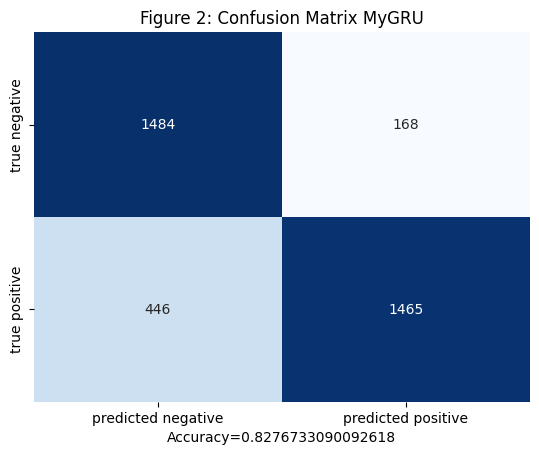

In [12]:
confusion_plot(labels, preds, "MyGRU", 2)
plt.show()

## Sentiment Analysis Using `torch.nn.GRU`

In [13]:
nnGruModel = SentimentGRUWrapper(nn.GRU(300, 100), 1)
# losses = train(nnGruModel, trainDataloader)

# torch.save(nnGruModel.state_dict(), "nngru_sentiment_model")
# np.savetext("nngru_train_loss", losses)

nnGruModel.load_state_dict(torch.load("nngru_sentiment_model"))
losses = np.loadtxt("nngru_train_loss")

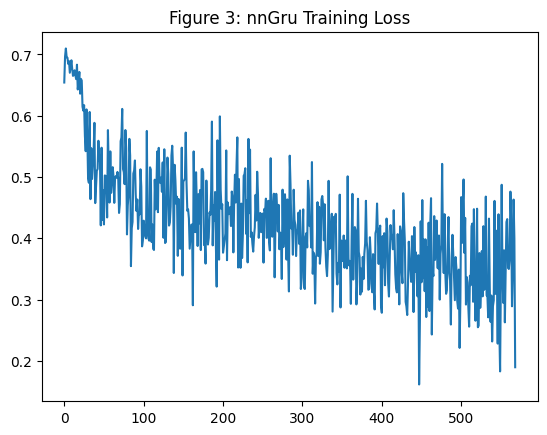

In [14]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Figure 3: nnGru Training Loss")
plt.show()

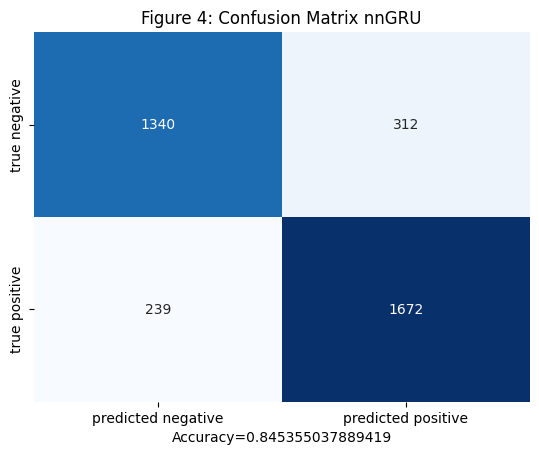

In [15]:
preds, labels = test(nnGruModel, testDataset, testDataloader)
confusion_plot(labels, preds, "nnGRU", 4)
plt.show()

In [16]:
nnbiGruModel = SentimentGRUWrapper(nn.GRU(300, 100, bidirectional=True), 1)
# losses = train(nnbiGruModel, trainDataloader)

# torch.save(nnbiGruModel.state_dict(), "nnbigru_sentiment_model")
# np.savetext("nnbigru_train_loss", losses)

nnbiGruModel.load_state_dict(torch.load("nnbigru_sentiment_model"))
losses = np.loadtxt("nnbigru_train_loss")

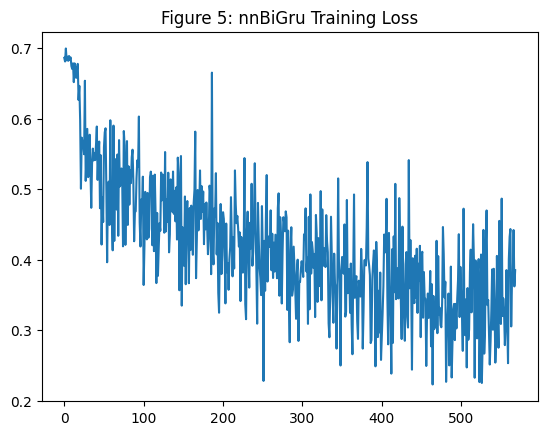

In [17]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Figure 5: nnBiGru Training Loss")
plt.show()

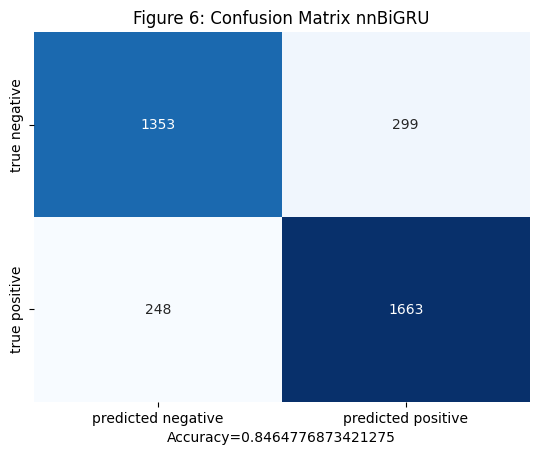

In [19]:
preds, labels = test(nnbiGruModel, testDataset, testDataloader)
confusion_plot(labels, preds, "nnBiGRU", 6)
plt.show()

The bidirectional mode and unidirectional nn.GRU performed similarly.
They were both however orders of magnitude faster to train then my implmentation of GRU. 
This is probably due to the for loop in python looping over the sequence elements and me splitting the linear blocks for the input and hidden layer (reasoning being that exectution would have to come back up to python level for each before descending back down to GPU operations, although there may be some torch optimizations here that don't make this an issue).

The nn.GRU had better accuruacy than my implmentation. 
This may be due to better weight initialization (assuming nn.GRU does something special with that) or that those models have more parameters than mine (nevermind see below).
Looking at the nn.GRU implmentation, the only difference is that the reset gate is done AFTER the previous hidden is passed through its linear layer and bias.
In my case it is done BEFORE.

In [21]:
numParams = lambda model: sum(p.numel() for p in myGruModel.parameters())
print(numParams(myGruModel))
print(numParams(nnGruModel))
print(numParams(nnbiGruModel))

120802
120802
120802
